# Credit Card Fraud Detection

**Last updated:** 2021/05/19

# Introduction

In this notebook, we will explore the "Credit Card Fraud Detection" dataset and build a model to predict which transactions are legit and fraudulent. To describe the contents of the dataset, I will quote the original description:

> The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

> It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

We are informed that the dataset is highly unbalanced and that most variables are anonymized and were obtained via PCA transformation. Therefore, we will try a few strategies to handle imbalanced classification and incrementally build a model combining these techniques to optimize its performance. Here are some common approaches to deal with Imbalanced Data:

1. Resampling the Data, either undersampling or oversampling or a combination of both.
2. Generate Synthetic Data. Use GANs or other methods to create more data points.
3. Choosing a more appropriate performance metric. Selecting the wrong metric can generate misleading results.
4. Using different Class weights or Cost-sensitive models.
5. Collecting more data, in particular for the minority class if possible.
6. Frame the problem differently. Consider things like Anomaly Detection. 

## Importing the Libraries

In [1]:
!pip install -qqq -U scikit-learn scikit-plot imbalanced-learn seaborn

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

kmeans-smote 0.1.2 requires imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.8.0 which is incompatible.
kmeans-smote 0.1.2 requires numpy<1.16,>=1.13, but you'll have numpy 1.18.5 which is incompatible.
kmeans-smote 0.1.2 requires scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.24.2 which is incompatible.


In [2]:
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold
from sklearn.metrics import (matthews_corrcoef, roc_auc_score,
                             average_precision_score, f1_score)

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [3]:
# Set seed for reproducability
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Either to used previous grid search results or perform new search
USE_TUNED_PARAMS = True

# Loading the Data

We will define a customized `read_csv` method to optimize data types and use less memory.

In [4]:
def read_csv(file_path: str, nrows=None, dtype=np.float32) -> pd.DataFrame:
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
    dtypes = {x: dtype for x in column_names if
            x != 'Class'}
    dtypes['Class'] = np.int8
    return pd.read_csv(file_path, nrows=nrows, dtype=dtypes)

In [5]:
df = read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


# Data Exploration

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94812.664062,-6.765166e-07,-2.200436e-07,0.000002,0.000001,-2.162242e-07,-3.044802e-07,3.562525e-07,-1.653899e-07,1.252389e-07,...,-1.392230e-08,1.401162e-07,2.286466e-08,-2.529817e-08,-6.366587e-07,-1.851112e-07,-6.904835e-09,-3.216587e-09,88.322945,0.001727
std,47487.195312,1.958611e+00,1.651183e+00,1.516203,1.415832,1.380180e+00,1.332214e+00,1.237020e+00,1.194202e+00,1.098575e+00,...,7.344701e-01,7.256873e-01,6.244100e-01,6.056016e-01,5.212620e-01,4.822155e-01,4.035722e-01,3.300574e-01,250.071564,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-48.325588,-5.683171,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-0.890365,-0.848640,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,0.179846,-0.019847,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097605e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196,0.743341,6.119264e-01,3.985649e-01,5.704361e-01,3.273458e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165001,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382559,16.875343,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519588e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160156,1.000000


We will check if there are any missing values.

In [8]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

We will use a copy of the DataFrame to make modifications for visualization purposes only.

In [9]:
df_copy = df.copy()

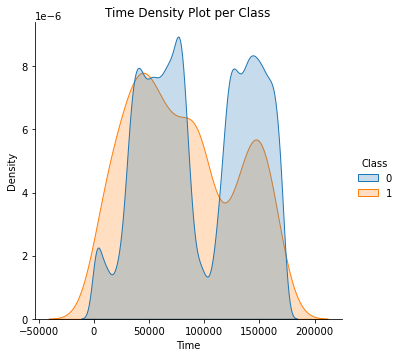

In [10]:
ax = sns.displot(df_copy, x='Time', hue='Class', kind='kde', fill=True, common_norm=False)
ax.set(title='Time Density Plot per Class')

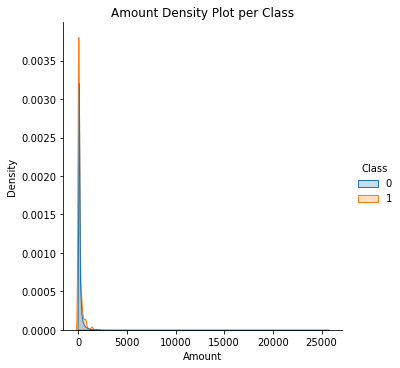

In [11]:
ax = sns.displot(df_copy, x='Amount', hue='Class', kind='kde', fill=True, common_norm=False)
ax.set(title='Amount Density Plot per Class')

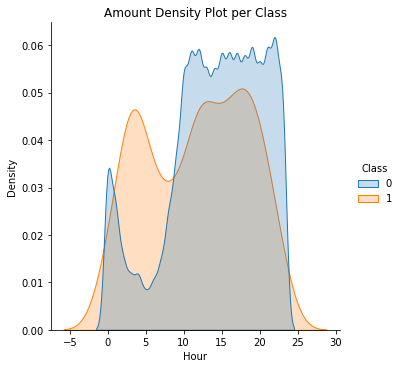

In [12]:
df_copy['Hour'] = df_copy['Time'].apply(lambda x: np.ceil(x / 3600) % 24)

ax = sns.displot(df_copy, x='Hour', hue='Class', kind='kde', fill=True, common_norm=False)
ax.set(title='Amount Density Plot per Class')

In [13]:
# This cell code was obtained from this source:
# https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models

tmp = df_copy.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
stats = pd.DataFrame(tmp)
stats.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
stats.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,10199.440430,10919,750813.937500,68.762154,14.400000,46255.160156
1,0.0,1,0.0,512.250000,21,3143.119873,149.672379,42.529999,31753.310547
2,1.0,0,0.0,7712.430176,7687,462282.281250,60.138191,12.140000,33692.777344
3,1.0,1,0.0,829.409973,6,1820.069946,303.345001,230.239990,123876.718750
4,2.0,0,0.0,2481.600098,4212,263171.250000,62.481300,18.980000,21216.832031


When we plot the volume of transactions per class grouped by hour of the day, we can observe some interesting patterns as fraud transactions seem to have spikes at specific hours and occur during typical sleeping hours.

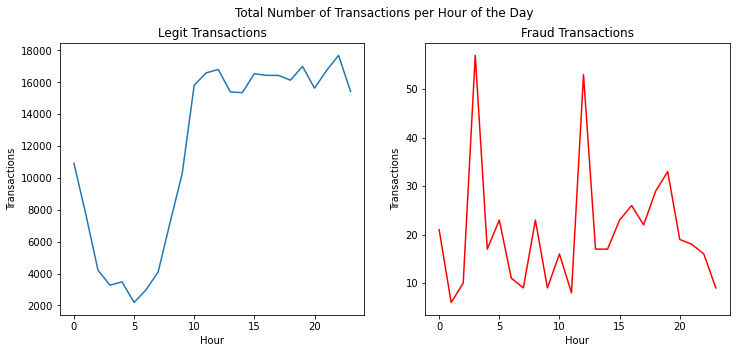

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.lineplot(x='Hour', y='Transactions', data=stats.query('Class == 0'), ax=ax[0])
sns.lineplot(x='Hour', y='Transactions', data=stats.query('Class == 1'), color='red', ax=ax[1])
fig.suptitle('Total Number of Transactions per Hour of the Day')
ax[0].set(title='Legit Transactions')
ax[1].set(title='Fraud Transactions')
fig.show()

# Data Preparation

To build the model, I incrementally increased the fraction of data used by 20% to adjust the model parameters progressively to avoid overfitting. For this final build, we will use the entirety of the dataset.

In [15]:
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [16]:
y = df['Class']
X = df.drop('Class', axis=1)

feature_names = X.columns.tolist()

As we can observe, the data is highly unbalanced, with less than 1% of positive fraud examples.

In [17]:
y.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

For the train/test split, we will divide them into 80% for the train data and 20% for the test data in a stratified fashion.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=SEED)

# Feature Engineering

We will compute some additional features containing statistical information about the anonymized variables.

In [19]:
def get_group_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create features by calculating statistical moments.
    
    :param df: Pandas DataFrame containing all features
    """
    cols = list(filter(lambda x: x.startswith('V'), df.columns))
    
    # avoid warnings about returning-a-view-versus-a-copy
    ds = df.copy()
    
    ds['V_mean'] = df[cols].mean(axis=1)
    ds['V_std'] = df[cols].std(axis=1)
    ds['V_skew'] = df[cols].skew(axis=1)
    
    return ds

X_train = get_group_stats(X_train)
X_test = get_group_stats(X_test)

In [20]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,V_mean,V_std,V_skew
9319,101691.0,2.113122,-0.067427,-1.062211,0.183495,0.154411,-0.585322,-0.166365,-0.246107,1.995113,...,0.439633,-1.133765,-0.631077,0.046039,-0.101130,-0.065391,9.91,-0.054216,1.051117,-0.050505
210502,72620.0,1.143742,0.174741,0.862678,1.052988,-0.666547,-0.569471,-0.211694,0.059470,0.007118,...,0.127981,0.469585,0.219076,-0.651484,0.028700,0.026081,9.99,0.145706,0.572725,0.400858
51455,141717.0,-1.502364,1.635901,-0.646716,0.359882,0.136560,-1.127764,0.249920,0.705085,0.144000,...,-0.158949,-0.092972,0.533375,-0.573315,-0.318169,-0.041170,1.99,-0.236430,0.796273,0.079623
128284,104458.0,-0.580486,0.721799,-1.554297,-1.735136,-0.122013,-0.069607,3.386795,-0.889773,0.539206,...,-0.313510,0.815592,0.198952,0.883310,-0.015340,0.017878,400.00,0.114818,1.246032,0.522092
251996,111058.0,-3.715441,4.175828,-2.217402,-1.207024,-0.075184,-0.972042,0.425504,0.317196,4.090196,...,0.148733,0.492251,0.091003,-0.209533,2.023499,1.224342,0.89,0.399176,1.810966,0.338856


We will train our model using cross-validation. To generate the splits, we will be applying a `GroupKFold` strategy. The group will be based on the **hour of the day** of the given transaction. From a previous plot, we could observe that specific hours have a higher volume of fraudulent transactions.

In [21]:
# Tested stratified kfold as well
sfold = StratifiedKFold(n_splits=3)

hour_train = X_train['Time'].apply(lambda x: np.ceil(float(x) / 3600) % 24)

gfold = GroupKFold(n_splits=3)
groups = list(gfold.split(X_train, y_train, groups=hour_train))

In [22]:
def plot_correlation(corr: str) -> plt.Axes:
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
def select_features_correlation(df: pd.DataFrame) -> list:
    # Calculate correlations with target
    full_corr = df.corr(method='spearman')
    corr_with_target = full_corr['Class'].T.apply(abs).sort_values(ascending=False)
    
    min_threshold = corr_with_target.quantile(.25)
    
    # Select features with highest correlation to the target variable
    features_correlation = corr_with_target[corr_with_target >= min_threshold]
    features_correlation.drop('Class', inplace=True)
    return features_correlation.index.tolist()

Because the data is highly unbalanced, it is difficult to see the correlation between some features. However, after experimenting with undersampling the data to reduce the number of examples of the majority class (legit transactions) and have equal class proportions, we can now see that the correlation values are more noticeable. We will use the correlation amount to select higher correlated features with our target class.

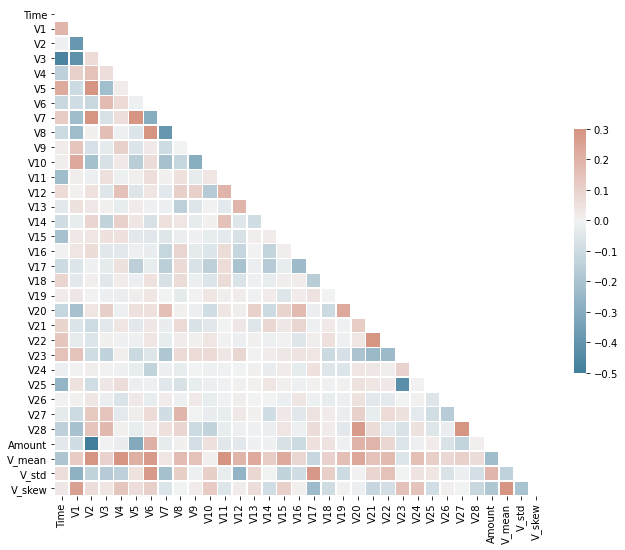

In [24]:
plot_correlation(X_train.corr(method='spearman'))

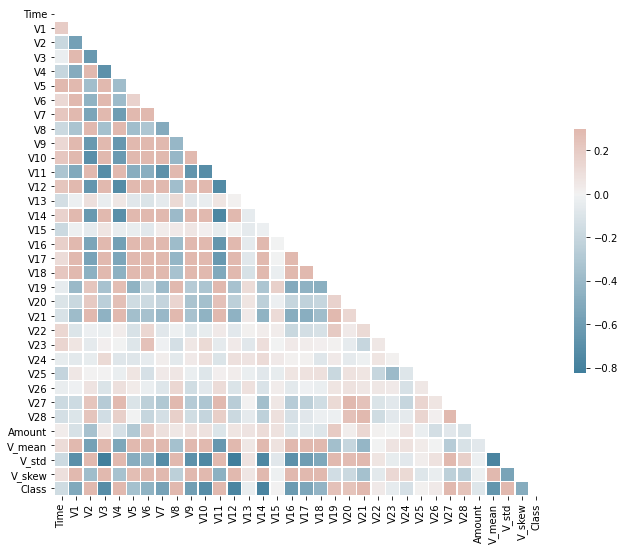

In [25]:
sampler = RandomUnderSampler(random_state=SEED)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
X_resampled['Class'] = y_resampled

plot_correlation(X_resampled.corr(method='spearman'))

We will select features that have a correlation with our target class higher than the lower quartile value. Dropping features with low correlation can help to reduce the complexity of the model.

In [26]:
cols = select_features_correlation(X_resampled)
X_train = X_train[cols]
X_test = X_test[cols]

# Modelling

We will use grid search to tune the hyperparameters of the model. And, we will apply cross-validation using the group fold strategy as mentioned above. To evaluate the performance:
- We will use the *F1-score*, a more relevant metric in this situation since false positives and false negatives are both critical.
- Using Accuracy in this scenario can output misleading results.
- We will use a maximum depth value to prevent overfitting the training data.
- We will test using different percentages of features used by each tree.
- Finally, we will try out two possibilities for the learning rate.
- I kept other parameters to fine-tune the alpha regularization value and the subsample of the training set for future changes.

## Baseline

First, we will train a simple baseline model with default parameters to have some initials results that we can compare with and identify what things we aim to improve.

In [27]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('clf', LGBMClassifier(n_jobs=-1, random_state=SEED)),
])

In [28]:
mcc_results = []
ap_results = []
roc_auc_results = []
f1_results = []

for train_index, test_index in groups:
    pipeline.fit(X_train.values[train_index], y_train.values[train_index])
    test_data = pipeline['standardscaler'].transform(X_train.values[test_index])
    
    y_pred = pipeline.predict(test_data)
    
    mcc_results.append(matthews_corrcoef(y_train.values[test_index], y_pred))
    ap_results.append(average_precision_score(y_train.values[test_index], y_pred))
    roc_auc_results.append(roc_auc_score(y_train.values[test_index], y_pred))
    f1_results.append(f1_score(y_train.values[test_index], y_pred))


print(f'Baseline MCC score: {np.mean(mcc_results)}')
print(f'Baseline AP score: {np.mean(ap_results)}')
print(f'Baseline ROC AUC score: {np.mean(roc_auc_results)}')
print(f'Baseline F1 score: {np.mean(f1_results)}')

Baseline MCC score: 0.09613585506472794
Baseline AP score: 0.017043358463682604
Baseline ROC AUC score: 0.6006605230375944
Baseline F1 score: 0.07692396099084955


## Fine-Tuning

In [29]:
gbm_grid = {
    'clf__n_estimators': [500, 1000],
    'clf__learning_rate': [0.1, 0.01],
    'clf__max_depth': [4, 6, 8],
    'clf__colsample_bytree': np.linspace(0.6, 1.0, num=5),
    # 'clf__reg_alpha': np.linspace(0., 1.0, num=5),
    # 'clf__subsample': np.linspace(0.7, 1.0, num=4),
}

In [30]:
def grid_search_tuning(pipeline, X, y, grid, fold):
    grid = HalvingGridSearchCV(pipeline, param_grid=grid, cv=fold, scoring='f1',
                               random_state=SEED, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    
    print(f"\nMean test score: {np.mean(grid.cv_results_['mean_test_score'])}")
    print(f'Best parameters: {grid.best_params_}')
    
    return grid.best_estimator_

In [31]:
if USE_TUNED_PARAMS:
    print('Using previously tuned model parameters.')
    
    best_params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 8,
        'clf__colsample_bytree': 0.6,
    }
    
    pipeline = Pipeline([
        ('standardscaler', StandardScaler()),
        ('clf', LGBMClassifier(**best_params, n_jobs=-1, random_state=SEED)),
    ])
    
    grid = pipeline.fit(X_train, y_train)
else:
    pipeline = Pipeline([
        ('standardscaler', StandardScaler()),
        ('clf', LGBMClassifier(n_jobs=-1, random_state=SEED)),
    ])

    # It can take a while to run
    grid = grid_search_tuning(pipeline, X_train, y_train, gbm_grid, groups)

Using previously tuned model parameters.


Model's performance evaluation on the test set and feature importance.

In [32]:
def score_model(clf, X_test, y_test, feature_names):
    y_pred = clf.predict(X_test)
    y_probas = clf.predict_proba(X_test)

    print(classification_report_imbalanced(y_test, y_pred, target_names=['Legit', 'Fraud']))
    print(f'MCC: {matthews_corrcoef(y_test, y_pred)}\nAP: ' +
          f'{average_precision_score(y_test, y_pred)}\nROC AUC: {roc_auc_score(y_test, y_pred)}')

    fig, ax = plt.subplots(1,2, figsize=(12,5))
    skplt.metrics.plot_precision_recall(y_test, y_probas, ax=ax[0])
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, ax=ax[1])
    fig.show()
    
    skplt.estimators.plot_feature_importances(clf, feature_names=feature_names, figsize=(16,5))

    return y_probas

                   pre       rec       spe        f1       geo       iba       sup

      Legit       1.00      1.00      0.82      1.00      0.90      0.83     56864
      Fraud       0.91      0.82      1.00      0.86      0.90      0.80        98

avg / total       1.00      1.00      0.82      1.00      0.90      0.83     56962

MCC: 0.8612367949974785
AP: 0.742431027969758
ROC AUC: 0.9080929220309395


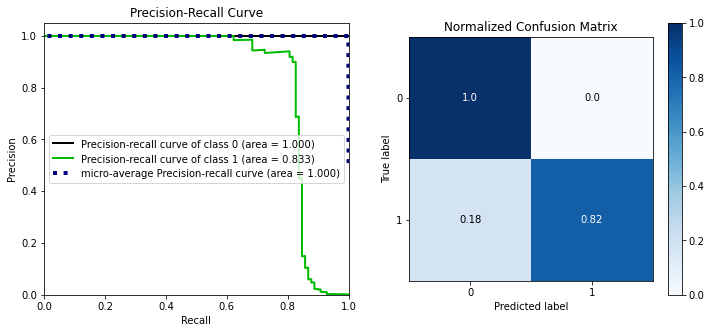

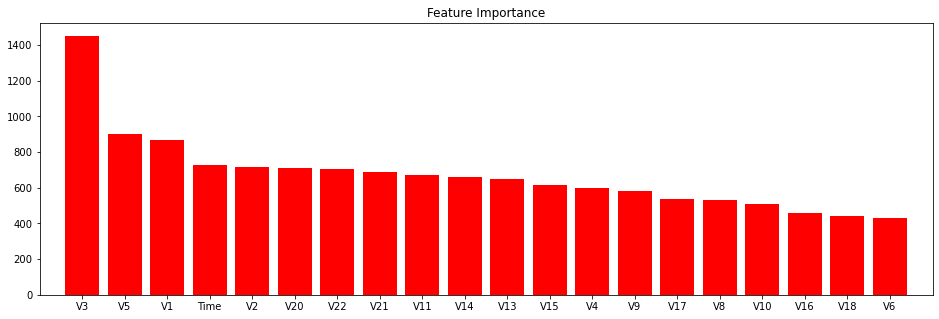

In [33]:
scaled_X_test = grid['standardscaler'].transform(X_test)

y_probas = score_model(grid['clf'], scaled_X_test, y_test, feature_names)

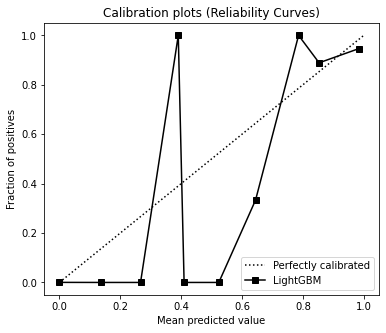

In [34]:
skplt.metrics.plot_calibration_curve(y_test, [y_probas], ['LightGBM'], figsize=(6,5))

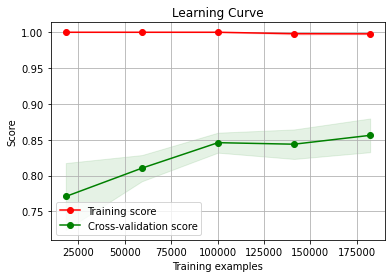

In [35]:
skplt.estimators.plot_learning_curve(grid['clf'], X_train, y_train, scoring='f1', n_jobs=-1, random_state=SEED)

# Conclusions

With this dataset, resampling the data didn't produce good results. Using under-sampling, over-sampling or a combination of both didn't improve compared with unchanged class proportions.
Perhaps, since most variables were from a PCA transformation, that affected the impact of sampling. Another potential reason is the very low number of fraudulent examples caused the under-sampling to produce a tiny dataset, lacking enough data to train a decent model.

I hope that this notebook has helpful and if you have any remarks or questions, feel free to leave a comment.

You can also follow me on Twitter [@hmatalonga](https://twitter.com/hmatalonga). I talk about Data Science, Machine Learning, among other topics I am interested in.